In [1]:
import numpy as np
from matplotlib import pyplot as plt

#import renamed libraries from the numerical toolbox
from local_signal import *
from general import *

import scipy.io.wavfile as wav
from IPython.display import Audio

Problem:

$\hat{a} = argmin_a ||a||_0 $, s.t.

$||y^r - M^r \phi a||_2^2 \leq \epsilon $

$a \in C^N$ : Synthesis coefficients

$\phi in C^{TxN}$ synthesis operator, Gabor Frames (STFT) is well suited for audio signals, therefore $\phi$ represents the matrix associated with the Gabor dictionary

$y^r = M^r y \in R^M$ the reliable samples

$y \in R^T $ the observed signal

$M^r \in R^{MxT} $ matrix comprised of those rows in the identity matrix that chooses the entries of reliable samples

$M^c \in R^{(T-M)xT} $ the matrix choosing the clipped samples,

$\theta^{clip} \in R^{(T-M)} $ the vector  of clipped samples which can only have values $\pm \theta^{clip}$

Problem becomes:

$ \hat{a} = argmin_a ||a||_0 $, s.t.

$ ||y^r - M^r \phi a||^2_2 \leq \epsilon $ and $ |M^c \phi a| \geq |\theta^{clip}|$

With the squared hinge function:

$ h^2 : R \to R_+, z \to    h^2(z) = z^2 , :if z \lt 0, else:  0$

if $ z = x - \theta^{clip} for \theta^{clip} \gt 0$,

squared hinge sets x "free" if $|x| \geq \theta^{clip}$, so we can use the notation:

$[\theta^{clip} - x]^2_+ = \sum_{k:\theta^{clip}_k\gt 0} h^2(x_k - \theta^{clip}_k) + \sum_{k:\theta^{clip}_k\lt 0} h^2(\theta^{clip}_k - x_k) $

unconstrained convex optimization problem:

$ argmin_a \frac{1}{2} ||y^r - M^r \phi a||^2_2 + \frac{1}{2} [\theta^{clip} - M^c \phi a]^2_+ + \lambda||a||_1$

Additionally:

$\phi$: tight Gabor frame as time-frequency dictionary

$\phi*$: The corresponding analysis operator aka Sliding Window or STFT;

$\gamma$: 0.9



In [3]:
music_rate, music_signal = wav.read('music.wav')
# convert music_signal to float and normalize to [-1, 1]
music_signal = music_signal.astype(np.float32) / np.max(np.abs(music_signal))
# display music object
Audio(music_signal, rate=music_rate)

In [4]:
# clip signal to values between -0.3 and 0.3
music_signal_clipped = np.clip(music_signal, -0.3, 0.3)
Audio(music_signal_clipped, rate=music_rate)


In [5]:
Jmin = 2

In [6]:
#import istft, stft
from scipy.signal import istft, stft
Psi = lambda a: istft(a, fs=music_rate, nperseg=1024, noverlap=512)[1]
PsiS = lambda a: stft(a, fs=music_rate, nperseg=1024, noverlap=512)[2]

In [192]:
def squared_hinge_clipped(x, clipping_values):
    """ 
    Computes the squared hinge loss, given the clipping values.
    """
    mask_negative_clips = clipping_values < 0
    mask_positive_clips = clipping_values > 0
    
    loss = np.zeros_like(x)
    loss[mask_negative_clips] = np.min(0, clipping_values[mask_negative_clips] - x[mask_negative_clips])**2
    loss[mask_positive_clips] = np.min(0, x[mask_positive_clips] - clipping_values[mask_positive_clips])**2
 
    return loss.sum()

def hinge_clipped_grad(x, clipping_values):
    """ 
    Computes the gradient of the squared hinge loss with clipping.
    """
    grad = np.zeros_like(x)
    mask_negative_clips = clipping_values < 0
    mask_positive_clips = clipping_values > 0

    grad[mask_negative_clips] = 2 * (clipping_values[mask_negative_clips] - x[mask_negative_clips])
    grad[mask_positive_clips] = 2 * (x[mask_positive_clips] - clipping_values[mask_positive_clips])

    grad[grad > 0] = 0
    grad[mask_positive_clips] = -grad[mask_positive_clips]
    grad[mask_negative_clips] = grad[mask_negative_clips]
        
    return grad

In [193]:
def lasso_shrinkage(x, lambda_):
    """ 
    Computes the soft-thresholding operator.
        x: input signal in the time-frequency domain
        lambda_: threshold
    """ 
    result = 1 - lambda_ / np.abs(x)
    result[result < 0] = 0
    return result * x

def empirical_weiner(x, lambda_):
    """ 
    Computes the empirical Wiener filter.
        x: input signal in the time-frequency domain
        lambda_: threshold
    """ 
    result = 1 - lambda_**2 / np.abs(x)**2
    result[result < 0] = 0
    return result * x


$a^{(0)} \in C^N, z^{(0)} = a^{(0)}, k = 1, \delta = ||\phi \phi^*|| $

repeat:

$ g1 = -\phi^*M^{r^T}(y^r - M^r \phi z^{(k-1)})$

$ g2 = -\phi^* M^{c^T} [\theta^{clip} - M^c \phi z^{(k-1)}]_+ $

$ a^{(k)} = S_{\lambda / \delta} ( z^{(k-1)} - \frac{1}{\delta}(g1+g2))$

$ z^{(k)} = a^{(k)} + \gamma (a^{(k)} - a^{(k-1)})$

$ k = k + 1 $

until convergence

In [194]:
def snr(signal, computed_signal, mask=None):
    """ 
    Computes the signal to noise ratio. If a mask is provided, the SNR is computed only on the masked part of the signal.
    """
    if mask is None:
        return 20 * np.log10(np.sum(signal) / np.sum(signal - computed_signal))
    return 20 * np.log10(np.sum(signal[mask]) / np.sum((signal[mask] - computed_signal[mask])))

In [197]:
def declipping_ista(clipped_audio, clip_threshold, gamma, thresholding_function, lambdas_, n_iter=1000, i_between_lambdas=500):
    """ 
    Performs declipping using relaxed ISTA.
    assumption: delta = 1
    """
    lambda_i = 0
    lambda_ = lambdas_[lambda_i]

    audio_length = len(clipped_audio)
    #Mr: mask of unclipped values (reliable samples)
    #Mc: mask of clipped values
    values_below = clipped_audio < clip_threshold
    values_above = clipped_audio > -clip_threshold
    Mr = values_below * values_above
    Mc = ~Mr

    #theta_clip = clipped_audio[Mc]
    theta_clip = np.sign(clipped_audio[Mc]) * np.max(np.abs(clipped_audio[Mc]))
    #yr: reliable samples
    yr = clipped_audio[Mr]

    # initialize alpha, z
    frequency_domain = PsiS(clipped_audio)
    alpha = np.zeros_like(frequency_domain)
    alpha_prev = alpha.copy()
    z = alpha.copy()
    z_prev = z.copy()+1
    
    i_between_lambdas_start = 0
    # ISTA loop
    for i in range(n_iter):
        if i % 100 == 0:
            #this section is using signal that the algorithm should not have access to; it's just for monitoring progress
            computed_snr = snr(music_signal, Psi(z)[:audio_length], mask=Mc)
            print('Iteration: ', i, ' SNR: ', computed_snr)
        g1 = Psi(z)[:audio_length]
        g1 = g1[Mr]
        g1 = yr - g1
        temp_g1 = np.zeros_like(clipped_audio)
        temp_g1[Mr] = g1
        g1 = -PsiS(temp_g1)

        g2 = Psi(z)[:audio_length]
        g2 = g2[Mc]
        
        #this will be ugly
        #########
        g2 = 0.5 * hinge_clipped_grad(g2, theta_clip)
        ############
        #this was ugly

        temp_g2 = np.zeros_like(clipped_audio)
        temp_g2[Mc] = g2
        # print(temp_g2[3000:3100])
        g2 = -PsiS(temp_g2)
        # g2 = np.zeros_like(g1)

        alpha = thresholding_function(z - (1./1.) * (g1 + g2), lambda_)
        z = alpha + gamma*(alpha - alpha_prev)
        alpha_prev = alpha.copy()
        #check if we have converged
        if np.allclose(z, z_prev) or i - i_between_lambdas_start == i_between_lambdas:
            if i - i_between_lambdas_start == i_between_lambdas:
                print("Changing current lambda because of too many iterations")
            print('Reached iteration ', i, ' with lambda = ', lambda_, ' and SNR (masked) = ', snr(music_signal, Psi(z)[:audio_length], mask=Mc).round(2), ' and SNR (unmasked) = ', snr(music_signal, Psi(z)[:audio_length]).round(2))
            if lambda_i == len(lambdas_) - 1:
                break
            lambda_i += 1
            lambda_ = lambdas_[lambda_i]
            i_between_lambdas_start = i

        z_prev = z.copy()
            
    unclipped_audio = Psi(z)[:audio_length]
    # replace reliable samples with original values
    unclipped_audio_replaced = unclipped_audio.copy()
    unclipped_audio_replaced[Mr] = clipped_audio[Mr]
    return unclipped_audio, unclipped_audio_replaced

In [209]:
clip_threshold = 0.2
clipped_audio = np.clip(music_signal, -clip_threshold, clip_threshold)
gamma = 0.9
# thresholding_function = lasso_shrinkage
thresholding_function = empirical_weiner
lambdas_ = np.logspace(-1, -4, 10)
# lambdas_ = [1e-1, 9e-2, 8.5e-2, 8e-2]

n_iter = 100000
i_between_lambdas = 1000

unclipped_audio, unclipped_audio_replaced = declipping_ista(clipped_audio, clip_threshold, gamma, thresholding_function, lambdas_, n_iter, i_between_lambdas)


Iteration:  0  SNR:  0.0
Reached iteration  1  with lambda =  0.1  and SNR (masked) =  0.0  and SNR (unmasked) =  0.0
Iteration:  100  SNR:  -2.159678190946579
Reached iteration  133  with lambda =  0.046415888336127795  and SNR (masked) =  -2.16  and SNR (unmasked) =  1.1


C:\Users\DEUS-D~1\AppData\Local\Temp/ipykernel_15304/1638344606.py:7: RuntimeWarning: invalid value encountered in log10
  return 20 * np.log10(np.sum(signal[mask]) / np.sum((signal[mask] - computed_signal[mask])))


Iteration:  200  SNR:  nan
Reached iteration  277  with lambda =  0.021544346900318846  and SNR (masked) =  nan  and SNR (unmasked) =  -0.05
Iteration:  300  SNR:  nan
Iteration:  400  SNR:  nan
Reached iteration  441  with lambda =  0.01  and SNR (masked) =  nan  and SNR (unmasked) =  -10.49
Iteration:  500  SNR:  56.09834671020508
Iteration:  600  SNR:  33.56313228607178


C:\Users\DEUS-D~1\AppData\Local\Temp/ipykernel_15304/1638344606.py:6: RuntimeWarning: invalid value encountered in log10
  return 20 * np.log10(np.sum(signal) / np.sum(signal - computed_signal))


Reached iteration  665  with lambda =  0.004641588833612782  and SNR (masked) =  33.49  and SNR (unmasked) =  nan
Iteration:  700  SNR:  nan
Iteration:  800  SNR:  nan
Iteration:  900  SNR:  nan
Reached iteration  924  with lambda =  0.0021544346900318843  and SNR (masked) =  nan  and SNR (unmasked) =  -1.01
Iteration:  1000  SNR:  nan
Iteration:  1100  SNR:  nan
Iteration:  1200  SNR:  nan
Iteration:  1300  SNR:  nan
Iteration:  1400  SNR:  nan
Reached iteration  1460  with lambda =  0.001  and SNR (masked) =  nan  and SNR (unmasked) =  -5.18
Iteration:  1500  SNR:  nan
Iteration:  1600  SNR:  nan
Iteration:  1700  SNR:  nan
Iteration:  1800  SNR:  nan
Iteration:  1900  SNR:  nan
Iteration:  2000  SNR:  nan
Iteration:  2100  SNR:  nan
Iteration:  2200  SNR:  nan
Reached iteration  2252  with lambda =  0.0004641588833612782  and SNR (masked) =  nan  and SNR (unmasked) =  -7.66
Iteration:  2300  SNR:  nan
Iteration:  2400  SNR:  nan
Iteration:  2500  SNR:  nan
Iteration:  2600  SNR:  na

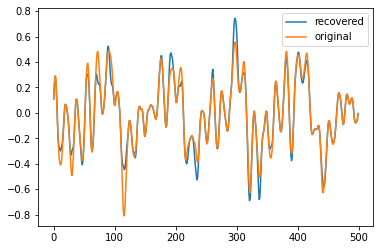

In [210]:
interval = 45000
plt.plot(unclipped_audio[interval:interval+500])
plt.plot(music_signal[interval:interval+500])
plt.legend(['recovered', 'original'])
plt.show()

In [211]:
# display unclipped audio
Audio(unclipped_audio, rate=music_rate)

In [212]:
Audio(clipped_audio, rate=music_rate)

In [213]:
Audio(music_signal, rate=music_rate)

In [204]:
# display unclipped audio
Audio(unclipped_audio_replaced, rate=music_rate)

In [145]:
unclipped_audio

array([ 0.00564193, -0.00463892, -0.01253761, ..., -0.04701605,
        0.00608074,  0.04403837], dtype=float32)

In [146]:
clipped_audio

array([ 0.00564193, -0.00463892, -0.01253761, ..., -0.04701605,
        0.00608074,  0.04403837], dtype=float32)

In [147]:
Audio(clipped_audio, rate=music_rate)

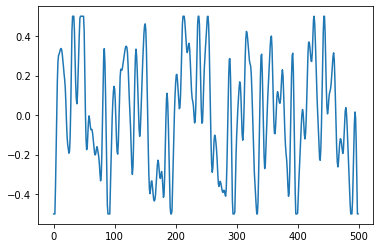

In [19]:
interval = 81000
plt.plot(clipped_audio[interval:interval+500])

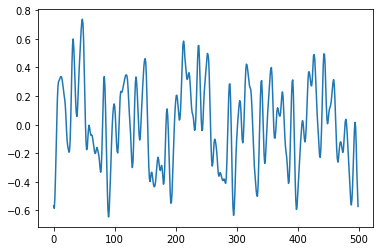

In [20]:
plt.plot(unclipped_audio_replaced[interval:interval+500])

In [15]:
import numpy as np
from scipy.signal import stft, istft
signal = music_signal
def compute_delta(signal, window_length, time_shift, sampling_freq):
    # Perform STFT
    _, _, stft_matrix = stft(signal, fs=sampling_freq, window='hann', nperseg=window_length, noverlap=window_length - time_shift)

    # Perform ISTFT
    _, signal_reconstructed = istft(stft_matrix, fs=sampling_freq, window='hann', nperseg=window_length, noverlap=window_length - time_shift)

    # Compute the norm of the difference between original and reconstructed signals
    delta = np.linalg.norm(signal - signal_reconstructed[:len(signal)])
    
    return delta


window_length = 1024
time_shift = 256
sampling_freq = 16000

delta_value = compute_delta(signal, window_length, time_shift, sampling_freq)
print(f"Delta value: {delta_value}")

Delta value: 7.834969437681139e-06


In [ ]:
delta_value = 7.83496e-6